In [ ]:
# TODO: once POD/FAR added all the way, load in appropriate subsets.


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils_datetime import *
from utils_filter import *

In [7]:
contingencies = xr.load_dataset('data/contingency/contingency.nc')

In [8]:
test_pods = np.divide(contingencies['a'], contingencies['a'] + contingencies['c'].values)
test_fars = np.divide(contingencies['b'].values, contingencies['a'].values + contingencies['b'].values)

C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\4122346570.py:2: RuntimeWarning: invalid value encountered in divide
  test_fars = np.divide(contingencies['b'].values, contingencies['a'].values + contingencies['b'].values)


In [33]:
pods = []
fars = []
hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']

# create yearly POD/FAR
for hazard in hazard_types:
    hazard_pod = []
    hazard_far = []
    for i in range(2002, 2023):
        subset = contingencies.sel(time=contingencies['time'].where(contingencies['time'].str.startswith(str(i)), drop=True), hazard = hazard)
        hazard_pod.append(subset['a'].values.sum()/(subset['a'].values.sum() + subset['c'].values.sum()))
        hazard_far.append(subset['b'].values.sum()/(subset['a'].values.sum() + subset['b'].values.sum()))
    pods.append(np.array(hazard_pod))
    fars.append(np.array(hazard_far))
        


In [9]:
# Adapted from https://gist.github.com/djgagne/64516e3ea268ec31fb34

def performance_diagram(pods, fars, obj_labels, colors, markers, filename = '', save = False, show = True, figsize=(9, 8), xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True)):
    """
    Draws a performance diagram from a set of POD lists and FAR lists.
    :param pods: list or array of POD arrays.
    :param fars: list or array of FAR arrays.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param save: whether the figure will be saved
    :param show: whether the figure will be shown in the console
    :param figsize: tuple with size of the figure in inches.
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :return:
    """
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [.25, 0.5, 1, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.2f", manual=[(0.2, 0.9), (0.4, 0.9), (0.7, 0.7), (.9, .4), (.9, .2)])
    for r, pod, far in zip(range(len(pods)), pods, fars):
        plt.plot(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r])
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.text(0.48,0.6,"Frequency Bias",fontdict=dict(fontsize=14, rotation=45))
    plt.legend(**legend_params)
    if save:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:27: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


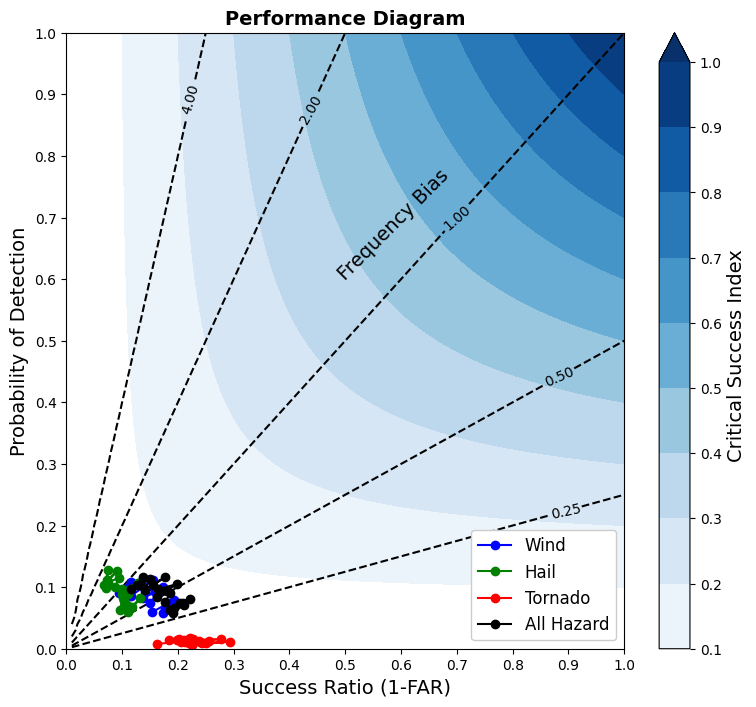

In [37]:


# performance diagram year-by-year
performance_diagram(pods, fars, hazard_types, ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'])

C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:27: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


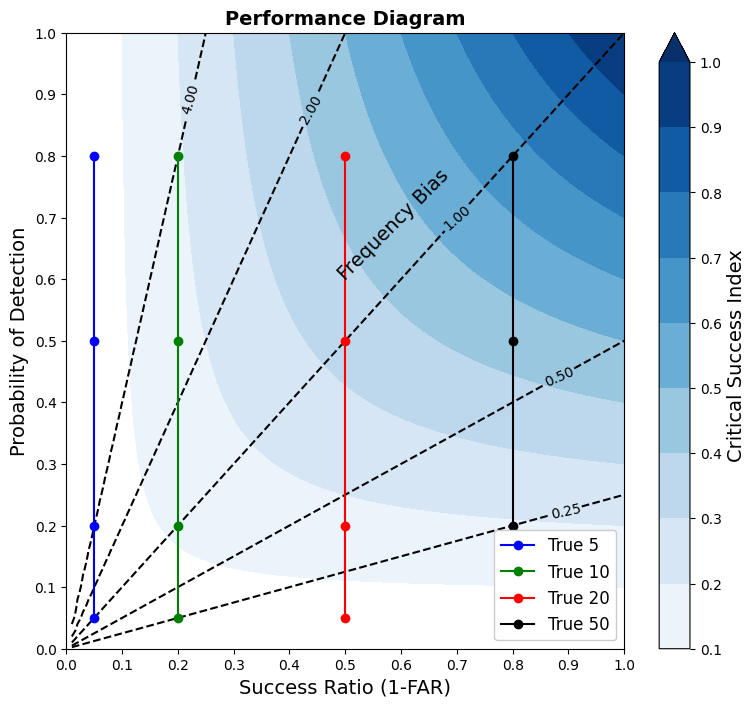

In [52]:
pods = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
fars = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
for i, p in enumerate([.05, .2, .5, .8]):
    for j, v in enumerate([.05, .2, .5, .8]):
        a = p * v
        b = p * (1-v)
        c = (1-p) * v
        pods[j][i] = a / (a + c)
        fars[j][i] = b / (a + b)

performance_diagram(pods, fars, ['True 5', 'True 10', 'True 20', 'True 50'], ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'])

C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:26: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_4776\2334131207.py:27: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


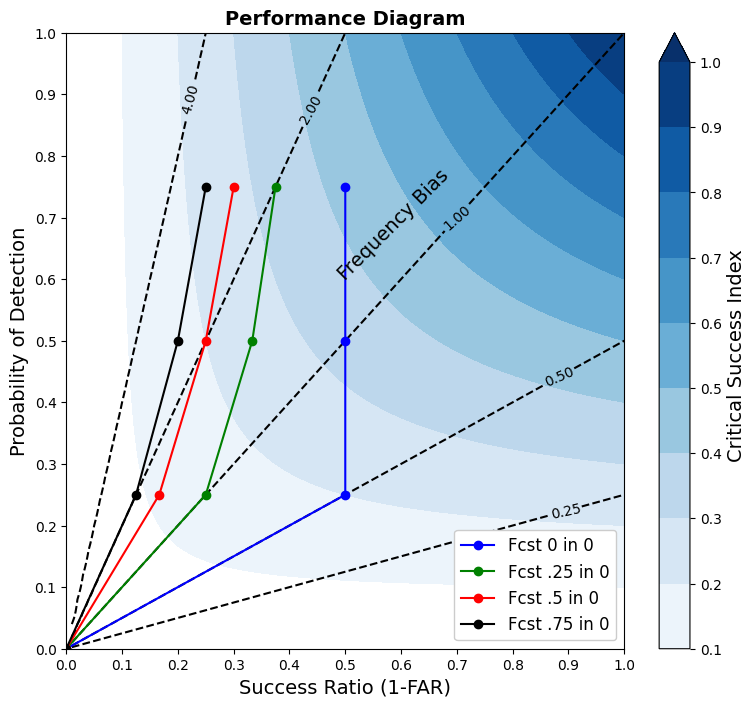

In [56]:
pods = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
fars = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
for i, p in enumerate([0, .25, .5, .75]):
    for j, v in enumerate([0, .25, .5, .75]):
        a = p * .5
        b = p * .5 + v * 1
        if b == 0:
            b = 1
        c = (1-p) * .5
        pods[j][i] = a / (a + c)
        fars[j][i] = b / (a + b)

performance_diagram(pods, fars, ['Fcst 0 in 0', 'Fcst .25 in 0', 'Fcst .5 in 0', 'Fcst .75 in 0'], ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'])